## Get Tiled Embeddings
This script gets BERT embeddings on varying tiled windows of utterances of the CANDOR data set.

**Author:** Helen Schmidt  
**Python version:** 3.11.13

## SETUP

In [2]:
import os
import pandas as pd
import numpy as np
import math
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define data input location
input_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/CANDOR/transcripts/raw"
# define data output location
output_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/full-sample"

In [4]:
# load pre-trained sentence transformer model (aka SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')

## LOAD TRANSCRIPTS

In [5]:
# load all modified transcripts and combine into one data frame
all_dfs = []
for dirpath, dirnames, filenames in os.walk(input_dir):
    for filename in filenames:
        if filename == 'transcript_backbiter_transformed_noLine1.csv':
            file_path = os.path.join(dirpath, filename)
            df = pd.read_csv(file_path)
            relative_path = os.path.relpath(dirpath, input_dir)
            transcript_id = relative_path.split(os.sep)[0] if relative_path else ''
            # add new variable for transcript ID from folder name
            df['transcript_id'] = transcript_id
            all_dfs.append(df)

# Concatenate all dataframes by rows (like row bind)
df = pd.concat(all_dfs, ignore_index=True)

df.to_csv(output_dir + "/all_transcripts.csv", index=False)

In [6]:
# preview data frame
df.head()

,turn_id,speaker,start,stop,utterance,backchannel,backchannel_count,backchannel_speaker,backchannel_start,backchannel_stop,interval,delta,questions,end_question,overlap,n_words,transcript_id
0,0,5c8be0dd542fbd0016924f5f,78.44,83.36,"No, I'm good. How are you?",NaN,0,NaN,NaN,NaN,20.18,4.92,1,True,False,6,3a51d3fd-a343-4177-b48e-a694a14c5891
1,1,5f2f6bd965964e35e20c7445,78.94,81.56,"No. Hi, how are you?",NaN,0,NaN,NaN,NaN,-0.31,2.62,1,True,True,5,3a51d3fd-a343-4177-b48e-a694a14c5891
2,2,5f2f6bd965964e35e20c7445,83.94,85.26,Good thanks.,NaN,0,NaN,NaN,NaN,0.58,1.32,0,False,False,2,3a51d3fd-a343-4177-b48e-a694a14c5891
3,3,5c8be0dd542fbd0016924f5f,85.44,90.06,Hm My name is played to me,Mhm.,1,5f2f6bd965964e35e20c7445,87.74,88.76,0.18,4.62,0,False,False,7,3a51d3fd-a343-4177-b48e-a694a14c5891
4,4,5f2f6bd965964e35e20c7445,89.44,92.16,"Hi, my name's Amanda.",NaN,0,NaN,NaN,NaN,-0.24,2.72,0,False,True,4,3a51d3fd-a343-4177-b48e-a694a14c5891


### select variables for tiling function

In [7]:
# only need a few variables from df for tiling
selected_df = df[['turn_id', 'speaker', 'utterance', 'transcript_id', 'start', 'stop']]

# calculate turn length in seconds (stop - start)
selected_df['turn_length_s'] = selected_df['stop'] - selected_df['start']

# also create a test subset to make sure tiling function works 
test_df = selected_df.head(10).copy()

# preview subset
selected_df.head()

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_78266/2333803167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['turn_length_s'] = selected_df['stop'] - selected_df['start']


,turn_id,speaker,utterance,transcript_id,start,stop,turn_length_s
0,0,5c8be0dd542fbd0016924f5f,"No, I'm good. How are you?",3a51d3fd-a343-4177-b48e-a694a14c5891,78.44,83.36,4.92
1,1,5f2f6bd965964e35e20c7445,"No. Hi, how are you?",3a51d3fd-a343-4177-b48e-a694a14c5891,78.94,81.56,2.62
2,2,5f2f6bd965964e35e20c7445,Good thanks.,3a51d3fd-a343-4177-b48e-a694a14c5891,83.94,85.26,1.32
3,3,5c8be0dd542fbd0016924f5f,Hm My name is played to me,3a51d3fd-a343-4177-b48e-a694a14c5891,85.44,90.06,4.62
4,4,5f2f6bd965964e35e20c7445,"Hi, my name's Amanda.",3a51d3fd-a343-4177-b48e-a694a14c5891,89.44,92.16,2.72


### determine max window sizes across transcripts

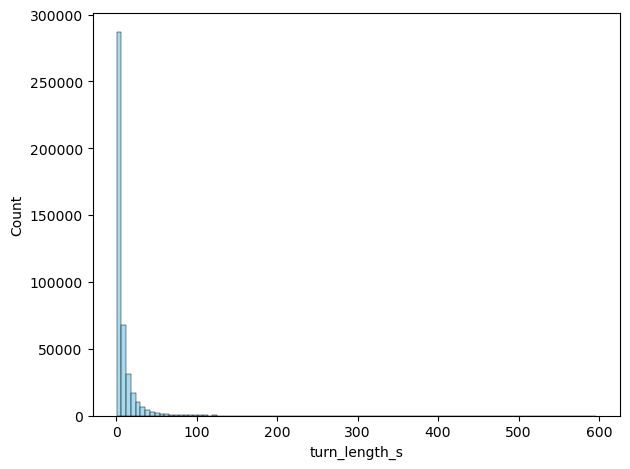

0.10     0.51
0.25     1.22
0.50     3.63
0.75     8.52
0.90    18.62
0.99    54.62
Name: turn_length_s, dtype: float64

In [8]:
# look at distribution of window lengths in the data
sns.histplot(selected_df['turn_length_s'], bins=100, kde=False, color='skyblue')
plt.tight_layout()
plt.show()

# print quantiles
selected_df['turn_length_s'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

In [9]:
# how many transcripts have an utterance greater than 1 minute (60 seconds)
count_60 = selected_df.groupby("transcript_id")["turn_length_s"].apply(lambda x: (x > 60).any()).sum()

# how many with greater than 90 seconds?
count_90 = selected_df.groupby("transcript_id")["turn_length_s"].apply(lambda x: (x > 90).any()).sum()

# if a transcript has an utterance greater than 60 seconds, how many turns, on average, are greater than 60 seconds?
over_60_avg = selected_df[selected_df["turn_length_s"] > 60].groupby("transcript_id").size().mean()

# what about average count over 90 seconds?
over_90_avg = selected_df[selected_df["turn_length_s"] > 90].groupby("transcript_id").size().mean()

# what is our longest turn?
max_length = selected_df['turn_length_s'].max()
# and what transcript is it in?
transcript_with_max = selected_df.loc[selected_df['turn_length_s'] == max_length, ['transcript_id', 'turn_id']]

# this transcript left NPR playing, let's find our actual longest conversation turn!
second_largest = selected_df['turn_length_s'].nlargest(2).iloc[-1]
transcript_with_second = selected_df.loc[selected_df['turn_length_s'] == second_largest, ['transcript_id', 'turn_id']]

# that transcript had audio issues, what about third longest?
third_largest = selected_df['turn_length_s'].nlargest(3).iloc[-1]
transcript_with_third = selected_df.loc[selected_df['turn_length_s'] == third_largest, ['transcript_id', 'turn_id']]

# more audio issues, fourth?
fourth_largest = selected_df['turn_length_s'].nlargest(4).iloc[-1]
transcript_with_fourth = selected_df.loc[selected_df['turn_length_s'] == fourth_largest, ['transcript_id', 'turn_id']]

print(count_60, over_60_avg, count_90, over_90_avg, max_length, transcript_with_max, fourth_largest, transcript_with_fourth)

1050 3.078095238095238 452 1.8584070796460177 596.4                               transcript_id  turn_id
12185  208392ba-e44a-4d2b-be77-1927ad69bc5e        7 439.03                                transcript_id  turn_id
249645  d70e5a84-c195-4832-8862-07f85cda138a        0


In [10]:
# find the longest conversation-based turn
n_largest = selected_df['turn_length_s'].nlargest(5).iloc[-1]
transcript_largest_n = selected_df.loc[selected_df['turn_length_s'] == n_largest, ['transcript_id', 'turn_id']]
print(n_largest, transcript_largest_n)

420.77                                transcript_id  turn_id
112078  7c289d19-4fe7-4657-8ada-7b452642602c       89


### break up long utterances

#### maintaining sentence structure

In [14]:
# define sentence splitting function
def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    return [s for s in sentences if s]

# break up long utterances, maintaining sentence structure
new_rows = []

# sort input data frame
hold_df = selected_df.sort_values(["transcript_id", "turn_id"]).reset_index(drop=True)

for _, row in hold_df.iterrows():
    transcript_id = row["transcript_id"]
    turn_id = row["turn_id"]
    utterance = row["utterance"]
    duration = row["turn_length_s"]
    speaker = row['speaker']
    start_time = row['start']
    end_time = row['stop']

    # determine number of bins by duration (duration / max length desired)
    n_bins = max(1, math.ceil(duration / 30))

    # if no splitting needed
    if n_bins == 1:
        new_rows.append({
            "transcript_id": transcript_id,
            "speaker": speaker,
            "turn_id": turn_id,
            "utterance": utterance,
            "turn_length": duration,
            "start": start_time,
            "stop": end_time
        })
        continue

    # split based on sentences
    sentences = split_into_sentences(utterance)
    sent_word_counts = [len(s.split()) for s in sentences]
    total_words = sum(sent_word_counts)

    # approx words per bin
    target_bin_words = math.ceil(total_words / n_bins)

    # build chunks
    current_chunk = []
    current_word_count = 0

    chunks = []
    for sent, wc in zip(sentences, sent_word_counts):
        # If adding this sentence exceeds target bin size → start a new chunk
        if current_chunk and current_word_count + wc > target_bin_words:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sent]
            current_word_count = wc
        else:
            current_chunk.append(sent)
            current_word_count += wc

    # last chunk
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    # duration per chunk
    bin_duration = duration / len(chunks)

    # append chunks as new rows
    for chunk in chunks:
        new_rows.append({
            "transcript_id": transcript_id,
            "speaker": speaker,
            "turn_id": turn_id,
            "utterance": chunk,
            "turn_length": bin_duration,
            "start": start_time,
            "stop": end_time
        })

# final df
df_split_sentence = pd.DataFrame(new_rows)
df_split_sentence = df_split_sentence.sort_values(["transcript_id", "turn_id"]).reset_index(drop=True)

df_split_sentence.head()

,transcript_id,speaker,turn_id,utterance,turn_length,start,stop
0,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,hey I'm gone.,1.02,200.74,201.76
1,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,"good, how are you? Yeah. Yeah, so this will be...",10.61,202.14,212.75
2,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,yeah I've done a few of these before they're not,1.59,212.44,214.03
3,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,I don't know.,1.32,213.24,214.56
4,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,4,too bad. Is this your first time doing?,3.72,214.03,217.75


#### split by word count

In [12]:
# break up long utterances
new_rows = []

# sort to ensure correct ordering of utterances
hold_df = selected_df.sort_values(["transcript_id", "turn_id"]).reset_index(drop=True)

for _, row in hold_df.iterrows():
    transcript_id = row["transcript_id"]
    turn_id = row["turn_id"]
    utterance = row["utterance"]
    duration = row["turn_length_s"]
    speaker = row['speaker']
    start_time = row['start']
    end_time = row['stop']

    # how many bins? duration / max desired length
    n_bins = max(1, math.ceil(duration / 30))

    # if no split needed, keep the row as-is
    if n_bins == 1:
        new_rows.append({
            "transcript_id": transcript_id,
            'speaker': speaker,
            "turn_id": turn_id,
            "utterance": utterance,
            "turn_length": duration,
            'start': start_time,
            'stop': end_time
        })

    else:
        # split by roughly equal word counts
        words = utterance.split()
        total_words = len(words)
        bin_size = math.ceil(total_words / n_bins)

        # get duration per bin
        bin_duration = duration / n_bins

        # get bin rows in correct order
        start = 0
        while start < total_words:
            chunk_words = words[start:start+bin_size]
            chunk_text = " ".join(chunk_words)

            new_rows.append({
                "transcript_id": transcript_id,
                'speaker': speaker,
                "turn_id": turn_id,
                "utterance": chunk_text,
                "turn_length": bin_duration,
                'start': start_time,
                'stop': end_time
            })

            start += bin_size

# recombine into final df
df_split = pd.DataFrame(new_rows)

# preserve final ordering
df_split = df_split.sort_values(["transcript_id", "turn_id"]).reset_index(drop=True)

# preview
df_split.head()


,transcript_id,speaker,turn_id,utterance,turn_length,start,stop
0,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,hey I'm gone.,1.02,200.74,201.76
1,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,"good, how are you? Yeah. Yeah, so this will be...",10.61,202.14,212.75
2,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,yeah I've done a few of these before they're not,1.59,212.44,214.03
3,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,I don't know.,1.32,213.24,214.56
4,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,4,too bad. Is this your first time doing?,3.72,214.03,217.75


## replace NANs with empty strings

In [15]:
# replace missing values in utterances with empty strings
df_split_sentence = df_split_sentence.fillna('')
df_split_sentence.head()

,transcript_id,speaker,turn_id,utterance,turn_length,start,stop
0,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,hey I'm gone.,1.02,200.74,201.76
1,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,"good, how are you? Yeah. Yeah, so this will be...",10.61,202.14,212.75
2,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,yeah I've done a few of these before they're not,1.59,212.44,214.03
3,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,I don't know.,1.32,213.24,214.56
4,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,4,too bad. Is this your first time doing?,3.72,214.03,217.75


In [16]:
# replace missing values in utterances with empty strings
df_split = df_split.fillna('')
df_split.head()

,transcript_id,speaker,turn_id,utterance,turn_length,start,stop
0,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,hey I'm gone.,1.02,200.74,201.76
1,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,"good, how are you? Yeah. Yeah, so this will be...",10.61,202.14,212.75
2,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,yeah I've done a few of these before they're not,1.59,212.44,214.03
3,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,I don't know.,1.32,213.24,214.56
4,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,4,too bad. Is this your first time doing?,3.72,214.03,217.75


### create test subset

In [17]:
# create test subset (sentence)
test_subset_sentence = df_split_sentence[df_split_sentence['transcript_id'].isin(df_split_sentence['transcript_id'].unique()[:5])]
test_subset_sentence.head()

,transcript_id,speaker,turn_id,utterance,turn_length,start,stop
0,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,hey I'm gone.,1.02,200.74,201.76
1,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,"good, how are you? Yeah. Yeah, so this will be...",10.61,202.14,212.75
2,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,yeah I've done a few of these before they're not,1.59,212.44,214.03
3,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,I don't know.,1.32,213.24,214.56
4,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,4,too bad. Is this your first time doing?,3.72,214.03,217.75


In [18]:
# create test subset (word)
test_subset = df_split[df_split['transcript_id'].isin(df_split['transcript_id'].unique()[:5])]
test_subset.head()

,transcript_id,speaker,turn_id,utterance,turn_length,start,stop
0,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,hey I'm gone.,1.02,200.74,201.76
1,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,"good, how are you? Yeah. Yeah, so this will be...",10.61,202.14,212.75
2,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,yeah I've done a few of these before they're not,1.59,212.44,214.03
3,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,I don't know.,1.32,213.24,214.56
4,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,4,too bad. Is this your first time doing?,3.72,214.03,217.75


## DEFINE TILING FUNCTION

Dec 2025 issues...
* when doing time-based analyses, I noticed that specifying a 30 second window with 30 second slide (i.e., no overlap) wound up still overlapping utterances contained in window A vs B for the same row
* I *think* this is because of the patchy time stamps we have from the CANDOR data
* Possible solution -- roughly create 30 second windows (or any time) by splitting and combining utterance turns?

In [26]:
# euclidean distance function
def euclidean_dist(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# tiling function for turn or time-based analyses
def tiled_cosine_similarity(
        df,
        model,
        mode='turn',              # "turn" or "time"
        window_size=5,            # turns or seconds depending on mode
        gap_size=0,               # turns or seconds depending on mode
        slide_size=None,          # how much to slide in turns or seconds
        time_col_start="start",
        time_col_end="stop"):
    
    """
    Compute cosine similarity and euclidean between tiled conversation windows, either based on turns or time windows.

    Parameters:
    -----------
    df : data frame containing utterances, transcript_id, and start/stop time and/or turn numbers
    model : embedding model with .encode() method
    mode : str; "turn" for turn-based windows and "time" for time-based windows (seconds)
    window_size : int or float; window size in number of turns or number of seconds
    gap_size : int or float; gap size in number of turns or number of seconds
    slide_size : int or float; how much to slide in time mode
    time_col_start : str; column identifying start times if in time mode
    time_col_end : str; column identifying end times if in time mode

    NOTE: If you want no overlap between the sliding windows, make sure your slide_size is the same as your window_size
    -----------
    """

    # create empty object to store results into
    results = []

    # loop through each transcript one at a time
    for idx, (transcript_id, group) in enumerate(df.groupby('transcript_id'), start=1):

        # ensure temporal order is maintained
        group = group.sort_values(by="turn_id").reset_index(drop=True)

        # establish relative timing (0 based)
        start_0 = group[time_col_start].iloc[0]
        group["rel_start"] = group[time_col_start] - start_0
        group["rel_end"]   = group[time_col_end]   - start_0
        group["raw_start"] = group[time_col_start]
        group["raw_end"]   = group[time_col_end]

        # print processing message to keep track of loop progress
        print(f"Processing transcript {idx}/{df['transcript_id'].nunique()}: {transcript_id}")

        # ====================================================================== #
        #                               TURN MODE                                #
        # ====================================================================== #
        if mode == "turn": # if working in turn mode...

            # get the max turn of this transcript
            max_turn = group["turn_id"].max()

            t = 0
            utterances = group["utterance"].tolist()
            for i in range(len(utterances) - window_size - gap_size):
                # note the start and end turns of each utterance
                A_start, A_end = t, t + window_size
                B_start = A_end + gap_size
                B_end   = B_start + window_size
                
                # concatenate windows of utterances
                window_A = " ".join(utterances[A_start:A_end])
                window_B = " ".join(utterances[B_start:B_end])

                if len(window_A) == 0 or len(window_B) == 0:
                    t += slide_size
                    continue

                # save out raw turns
                A_raw_start = group.iloc[A_start:A_end]["raw_start"].min()
                A_raw_end   = group.iloc[A_start:A_end]["raw_end"].max()
                B_raw_start = group.iloc[B_start:B_end]["raw_start"].min()
                B_raw_end   = group.iloc[B_start:B_end]["raw_end"].max()

                # get embeddings
                emb_A = model.encode(window_A).reshape(1, -1)
                emb_B = model.encode(window_B).reshape(1, -1)
                # alert if dimensional mismatch is found
                assert emb_A.shape[1] == emb_B.shape[1], \
                    f"Dim mismatch A={emb_A.shape[1]}, B={emb_B.shape[1]}"
                # calculate cosine similarity and euclidean distance between embeddings
                similarity = cosine_similarity(emb_A, emb_B)[0][0]
                distance   = euclidean_dist(emb_A, emb_B)
                # save to results!
                results.append({
                    'transcript_id': transcript_id,
                    'mode': mode,
                    'window_size': window_size,
                    'gap_size': gap_size,
                    # relative turns
                    'A_start_turn': A_start + 1,
                    'A_end_turn': A_end,
                    'B_start_turn': B_start + 1,
                    'B_end_turn': B_end,
                    # raw turns
                    'A_raw_start': A_raw_start,
                    'A_raw_end': A_raw_end,
                    'B_raw_start': B_raw_start,
                    'B_raw_end': B_raw_end,
                    # return utterances
                    'A_utterances': window_A,
                    'B_utterances': window_B,
                    # return embeddings
                    'A_embeddings': emb_A,
                    'B_embeddings': emb_B,
                    # return calculated metrics
                    'cosine_similarity': similarity,
                    'euclidean_distance': distance
                })

                t += slide_size

        # ====================================================================== #
        #                               TIME MODE                                #
        # ====================================================================== #
        elif mode == "time": # if in time mode...
            # get the max time of this transcript
            max_time = group["rel_end"].max()
            if slide_size is None:
                slide_size = window_size / 2

            t = 0
            while t + window_size + gap_size + window_size <= max_time:
                # get timing
                A_start, A_end = t, t + window_size
                B_start = A_end + gap_size
                B_end   = B_start + window_size
                # define the rows of utterances that fall between our set windows of time
                A_rows = group[(group["rel_start"] < A_end) & (group["rel_end"] > A_start)]
                B_rows = group[(group["rel_start"] < B_end) & (group["rel_end"] > B_start)]
                # join utterances that fall in the right time window
                window_A = " ".join(A_rows["utterance"].astype(str))
                window_B = " ".join(B_rows["utterance"].astype(str))

                if len(window_A) == 0 or len(window_B) == 0:
                    t += slide_size
                    continue
                # save out raw and relative start and end times
                A_raw_start = A_rows["raw_start"].min()
                A_raw_end   = A_rows["raw_end"].max()
                B_raw_start = B_rows["raw_start"].min()
                B_raw_end   = B_rows["raw_end"].max()
                # get embeddings
                emb_A = model.encode(window_A).reshape(1, -1)
                emb_B = model.encode(window_B).reshape(1, -1)
                # calculate cosine similarity and euclidean distance
                similarity = cosine_similarity(emb_A, emb_B)[0][0]
                distance   = euclidean_dist(emb_A, emb_B)
                # save results!
                results.append({
                    'transcript_id': transcript_id,
                    'mode': mode,
                    'window_size': window_size,
                    'gap_size': gap_size,
                    # time (relative)
                    'A_start_time': A_start,
                    'A_end_time': A_end,
                    'B_start_time': B_start,
                    'B_end_time': B_end,
                    # time (raw)
                    'A_raw_start': A_raw_start,
                    'A_raw_end': A_raw_end,
                    'B_raw_start': B_raw_start,
                    'B_raw_end': B_raw_end,
                    # utterances
                    'A_utterances': window_A,
                    'B_utterances': window_B,
                    # embeddings
                    'A_embeddings': emb_A,
                    'B_embeddings': emb_B,
                    # calculated metrics
                    'cosine_similarity': similarity,
                    'euclidean_distance': distance
                })

                t += slide_size

        else:
            raise ValueError("mode must be either 'turn' or 'time'") # raise error if mode isn't specified correctly

    return pd.DataFrame(results) # return results!

### testing tiling function

In [12]:
# run tiling function on test subset
test_tile = tiled_cosine_similarity(test_subset, model, mode='time', window_size=30, gap_size=0, 
                                    slide_size=30, time_col_start='start', time_col_end='stop')
# preview
test_tile.head()

Processing transcript 1/5: 0020a0c5-1658-4747-99c1-2839e736b481
Processing transcript 2/5: 002d68da-7738-4177-89d9-d72ae803e0e4
Processing transcript 3/5: 00411458-8275-4b92-a000-d52187f03604
Processing transcript 4/5: 00ae2f18-9599-4df6-8e3a-6936c86b97f0
Processing transcript 5/5: 00b410f7-8b5f-4404-8433-0fb8c4be8f62


,transcript_id,mode,window_size,gap_size,A_start_time,A_end_time,B_start_time,B_end_time,A_raw_start,A_raw_end,B_raw_start,B_raw_end,A_utterances,B_utterances,A_embeddings,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,0,30,30,60,200.74,230.46,231.64,269.36,"hey I'm gone. good, how are you? Yeah. Yeah, s...",not too bad. Feel a little crappy today but hu...,"[[0.049598813, -0.07489914, 0.067305245, 0.028...","[[-0.0116919065, 0.0357364, 0.06471551, -0.033...",0.209930,1.257037
1,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,30,60,60,90,231.64,269.36,251.04,294.56,not too bad. Feel a little crappy today but hu...,"thanks, Tiny firm sponge. I swear that's that'...","[[-0.0116919065, 0.0357364, 0.06471551, -0.033...","[[-0.0016286626, 0.0041150246, 0.08445076, -0....",0.659267,0.825510
2,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,60,90,90,120,251.04,294.56,281.96,326.95,"thanks, Tiny firm sponge. I swear that's that'...",that's awesome. So I have no kids myself not a...,"[[-0.0016286626, 0.0041150246, 0.08445076, -0....","[[-0.02322658, -0.047837097, 0.03072273, 0.116...",0.345367,1.144232
3,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,90,120,120,150,281.96,326.95,317.59,361.48,that's awesome. So I have no kids myself not a...,they've both been pretty good as far as stayin...,"[[-0.02322658, -0.047837097, 0.03072273, 0.116...","[[-0.03384363, -0.1098795, -0.0057394034, 0.07...",0.648501,0.838450
4,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,120,150,150,180,317.59,361.48,344.23,382.46,they've both been pretty good as far as stayin...,that sounds really cute. So what are their nam...,"[[-0.03384363, -0.1098795, -0.0057394034, 0.07...","[[-0.04442101, -0.065374166, 0.045213375, 0.03...",0.543921,0.955069


In [27]:
# run tiling function on test subset
test_tile = tiled_cosine_similarity(test_subset, model, mode='turn', window_size=4, gap_size=0, slide_size=4)
# preview
test_tile.head()

Processing transcript 1/5: 0020a0c5-1658-4747-99c1-2839e736b481
Processing transcript 2/5: 002d68da-7738-4177-89d9-d72ae803e0e4
Processing transcript 3/5: 00411458-8275-4b92-a000-d52187f03604
Processing transcript 4/5: 00ae2f18-9599-4df6-8e3a-6936c86b97f0
Processing transcript 5/5: 00b410f7-8b5f-4404-8433-0fb8c4be8f62


,transcript_id,mode,window_size,gap_size,A_start_turn,A_end_turn,B_start_turn,B_end_turn,A_raw_start,A_raw_end,B_raw_start,B_raw_end,A_utterances,B_utterances,A_embeddings,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,1,4,5,8,200.74,214.56,214.03,230.46,"hey I'm gone. good, how are you? Yeah. Yeah, s...",too bad. Is this your first time doing? this i...,"[[0.04145282, -0.00791257, 0.104940765, 0.1183...","[[0.03092037, -0.10058955, 0.0143238, -0.01912...",0.440620,1.057715
1,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,5,8,9,12,214.03,230.46,231.64,244.66,too bad. Is this your first time doing? this i...,not too bad. Feel a little crappy today but hu...,"[[0.03092037, -0.10058955, 0.0143238, -0.01912...","[[0.0076957764, -0.0027738144, 0.038302507, -0...",0.276866,1.202609
2,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,9,12,13,16,231.64,244.66,244.07,276.46,not too bad. Feel a little crappy today but hu...,the kid hasn't been feeling good and I think s...,"[[0.0076957764, -0.0027738144, 0.038302507, -0...","[[-0.042489365, 0.021653492, 0.09216961, -0.04...",0.522794,0.976940
3,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,13,16,17,20,244.07,276.46,277.02,317.65,the kid hasn't been feeling good and I think s...,22 girls if I'm that's awesome. So I have no k...,"[[-0.042489365, 0.021653492, 0.09216961, -0.04...","[[0.037868235, -0.0063665304, 0.023072034, 0.0...",0.177692,1.282426
4,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,17,20,21,24,277.02,317.65,317.59,333.26,22 girls if I'm that's awesome. So I have no k...,they've both been pretty good as far as stayin...,"[[0.037868235, -0.0063665304, 0.023072034, 0.0...","[[-0.019834107, -0.07536617, -0.018573657, 0.0...",0.332540,1.155388


## TURN-BASED TILING

In [36]:
# 12/11/25
# 4 utterances, no overlap
tile_4_utterance = tiled_cosine_similarity(df_split, model, mode='turn', window_size=4, gap_size=0, slide_size=4)
# save
tile_4_utterance.to_pickle(output_dir + "/full_sample_tile_4_turn_split_utterances.pkl")
tile_4_utterance.to_csv(output_dir + "/full_sample_tile_4_turn_split_utterances.csv", index = False)
# preview
tile_4_utterance.head()

Processing transcript 1/1656: 0020a0c5-1658-4747-99c1-2839e736b481
Processing transcript 2/1656: 002d68da-7738-4177-89d9-d72ae803e0e4
Processing transcript 3/1656: 00411458-8275-4b92-a000-d52187f03604
Processing transcript 4/1656: 00ae2f18-9599-4df6-8e3a-6936c86b97f0
Processing transcript 5/1656: 00b410f7-8b5f-4404-8433-0fb8c4be8f62
Processing transcript 6/1656: 00deb2e5-cf7f-4a5c-a8db-7fc335634ad6
Processing transcript 7/1656: 010a1b2a-7b69-4245-807f-d94eb6aa165c
Processing transcript 8/1656: 012dd705-ee62-49f6-8016-cf2e3cc066e4
Processing transcript 9/1656: 014a3227-9b4c-4f23-ad5b-8325235301ed
Processing transcript 10/1656: 015301b4-a132-4877-8bec-557e9b99a01c
Processing transcript 11/1656: 0159f2d4-f6db-46f8-b7c6-96a3df97b246
Processing transcript 12/1656: 01849238-f5f0-487e-bca4-7b4fe0c9625c
Processing transcript 13/1656: 01a4c01c-cf0e-4f37-ab2b-641bb604af30
Processing transcript 14/1656: 01a62310-06c3-4b69-9d75-50f1e2f1dabf
Processing transcript 15/1656: 01b9ad1a-cf5c-466b-b227-df

,transcript_id,mode,window_size,gap_size,A_start_turn,A_end_turn,B_start_turn,B_end_turn,A_raw_start,A_raw_end,B_raw_start,B_raw_end,A_utterances,B_utterances,A_embeddings,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,1,4,5,8,200.74,214.56,214.03,230.46,"hey I'm gone. good, how are you? Yeah. Yeah, s...",too bad. Is this your first time doing? this i...,"[[0.04145282, -0.00791257, 0.104940765, 0.1183...","[[0.03092037, -0.10058955, 0.0143238, -0.01912...",0.440620,1.057715
1,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,5,8,9,12,214.03,230.46,231.64,244.66,too bad. Is this your first time doing? this i...,not too bad. Feel a little crappy today but hu...,"[[0.03092037, -0.10058955, 0.0143238, -0.01912...","[[0.0076957764, -0.0027738144, 0.038302507, -0...",0.276866,1.202609
2,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,9,12,13,16,231.64,244.66,244.07,276.46,not too bad. Feel a little crappy today but hu...,the kid hasn't been feeling good and I think s...,"[[0.0076957764, -0.0027738144, 0.038302507, -0...","[[-0.042489365, 0.021653492, 0.09216961, -0.04...",0.522794,0.976940
3,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,13,16,17,20,244.07,276.46,277.02,317.65,the kid hasn't been feeling good and I think s...,22 girls if I'm that's awesome. So I have no k...,"[[-0.042489365, 0.021653492, 0.09216961, -0.04...","[[0.037868235, -0.0063665304, 0.023072034, 0.0...",0.177692,1.282426
4,0020a0c5-1658-4747-99c1-2839e736b481,turn,4,0,17,20,21,24,277.02,317.65,317.59,333.26,22 girls if I'm that's awesome. So I have no k...,they've both been pretty good as far as stayin...,"[[0.037868235, -0.0063665304, 0.023072034, 0.0...","[[-0.019834107, -0.07536617, -0.018573657, 0.0...",0.332540,1.155388


## TIME-BASED TILING

sections of 4 utterances; split long ones by sentence; no overlap; reduce long ones to 30s max

try grouping by speaker (i.e., my first 1 + 3, claire's first 2 plus 2 after my 3)

### 60 second windows, slide by 5 seconds

In [38]:
# 60 second windows!! (12/4/25)
# split up all long utterances into equally sized windows (equal word count assuming constant speech pace)
# tiling function
tile_60_sec = tiled_cosine_similarity(df_split, 
                                              model, 
                                              mode = 'time', 
                                              window_size=60, 
                                              gap_size=0, 
                                              slide_size=5)

# save
tile_60_sec.to_pickle(output_dir + "/full_sample_tile_60_sec_split_utterances.pkl")
tile_60_sec.to_csv(output_dir + "/full_sample_tile_60_sec_split_utterances.csv", index = False)
# preview
tile_60_sec.head()

Processing transcript 1/1656: 0020a0c5-1658-4747-99c1-2839e736b481
Processing transcript 2/1656: 002d68da-7738-4177-89d9-d72ae803e0e4
Processing transcript 3/1656: 00411458-8275-4b92-a000-d52187f03604
Processing transcript 4/1656: 00ae2f18-9599-4df6-8e3a-6936c86b97f0
Processing transcript 5/1656: 00b410f7-8b5f-4404-8433-0fb8c4be8f62
Processing transcript 6/1656: 00deb2e5-cf7f-4a5c-a8db-7fc335634ad6
Processing transcript 7/1656: 010a1b2a-7b69-4245-807f-d94eb6aa165c
Processing transcript 8/1656: 012dd705-ee62-49f6-8016-cf2e3cc066e4
Processing transcript 9/1656: 014a3227-9b4c-4f23-ad5b-8325235301ed
Processing transcript 10/1656: 015301b4-a132-4877-8bec-557e9b99a01c
Processing transcript 11/1656: 0159f2d4-f6db-46f8-b7c6-96a3df97b246
Processing transcript 12/1656: 01849238-f5f0-487e-bca4-7b4fe0c9625c
Processing transcript 13/1656: 01a4c01c-cf0e-4f37-ab2b-641bb604af30
Processing transcript 14/1656: 01a62310-06c3-4b69-9d75-50f1e2f1dabf
Processing transcript 15/1656: 01b9ad1a-cf5c-466b-b227-df

,transcript_id,mode,window_size,gap_size,A_start_time,A_end_time,B_start_time,B_end_time,A_raw_start,A_raw_end,B_raw_start,B_raw_end,A_utterances,B_utterances,A_embeddings,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,time,60,0,0,60,60,120,200.74,269.36,251.04,326.95,"hey I'm gone. good, how are you? Yeah. Yeah, s...","thanks, Tiny firm sponge. I swear that's that'...","[[-0.02723414, -0.016473606, 0.080718726, 0.01...","[[-0.060773935, -0.04257788, 0.07446801, 0.077...",0.565091,0.932640
1,0020a0c5-1658-4747-99c1-2839e736b481,time,60,0,5,65,65,125,202.14,269.36,251.04,326.95,"good, how are you? Yeah. Yeah, so this will be...","thanks, Tiny firm sponge. I swear that's that'...","[[-0.028731145, -0.014363082, 0.06715969, 0.01...","[[-0.060773935, -0.04257788, 0.07446801, 0.077...",0.576882,0.919911
2,0020a0c5-1658-4747-99c1-2839e736b481,time,60,0,10,70,70,130,202.14,274.65,268.44,333.26,"good, how are you? Yeah. Yeah, so this will be...",yeah the other one got sent home from school t...,"[[-0.048668917, -0.019317897, 0.06675714, 0.00...","[[-0.008008794, -0.04356668, 0.027158318, 0.09...",0.387899,1.106437
3,0020a0c5-1658-4747-99c1-2839e736b481,time,60,0,15,75,75,135,214.03,276.46,274.94,338.36,too bad. Is this your first time doing? this i...,you know how many kids do you have? 22 girls i...,"[[-0.030674124, -0.0073758666, 0.05366883, -0....","[[0.008727548, -0.07959748, 0.00069137814, 0.1...",0.321199,1.165162
4,0020a0c5-1658-4747-99c1-2839e736b481,time,60,0,20,80,80,140,217.30,282.12,277.02,343.76,this is actually my first one so yeah it's my ...,22 girls if I'm that's awesome. So I have no k...,"[[-0.049057648, -0.015586929, 0.060688626, -0....","[[0.032361522, -0.06461531, 0.0028393136, 0.10...",0.337325,1.151238


### 30 second windows, slide by 30 seconds (no overlap)

In [67]:
# 30 second windows, no overlap (12/8/25)
# tiling function
tile_30_sec = tiled_cosine_similarity(df_split, model, mode='time', window_size=30, gap_size=0, 
                                      slide_size=30, time_col_start='start', time_col_end='stop')

# save
tile_30_sec.to_pickle(output_dir + "/full_sample_tile_30_sec_split_utterances_no_overlap.pkl")
tile_30_sec.to_csv(output_dir + "/full_sample_tile_30_sec_split_utterances_no_overlap.csv", index = False)
# preview
tile_30_sec.head()

Processing transcript 1/1656: 0020a0c5-1658-4747-99c1-2839e736b481
Processing transcript 2/1656: 002d68da-7738-4177-89d9-d72ae803e0e4
Processing transcript 3/1656: 00411458-8275-4b92-a000-d52187f03604
Processing transcript 4/1656: 00ae2f18-9599-4df6-8e3a-6936c86b97f0
Processing transcript 5/1656: 00b410f7-8b5f-4404-8433-0fb8c4be8f62
Processing transcript 6/1656: 00deb2e5-cf7f-4a5c-a8db-7fc335634ad6
Processing transcript 7/1656: 010a1b2a-7b69-4245-807f-d94eb6aa165c
Processing transcript 8/1656: 012dd705-ee62-49f6-8016-cf2e3cc066e4
Processing transcript 9/1656: 014a3227-9b4c-4f23-ad5b-8325235301ed
Processing transcript 10/1656: 015301b4-a132-4877-8bec-557e9b99a01c
Processing transcript 11/1656: 0159f2d4-f6db-46f8-b7c6-96a3df97b246
Processing transcript 12/1656: 01849238-f5f0-487e-bca4-7b4fe0c9625c
Processing transcript 13/1656: 01a4c01c-cf0e-4f37-ab2b-641bb604af30
Processing transcript 14/1656: 01a62310-06c3-4b69-9d75-50f1e2f1dabf
Processing transcript 15/1656: 01b9ad1a-cf5c-466b-b227-df

,transcript_id,mode,window_size,gap_size,A_start_time,A_end_time,B_start_time,B_end_time,A_raw_start,A_raw_end,B_raw_start,B_raw_end,A_utterances,B_utterances,A_embeddings,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,0,30,30,60,200.74,230.46,231.64,269.36,"hey I'm gone. good, how are you? Yeah. Yeah, s...",not too bad. Feel a little crappy today but hu...,"[[0.049598813, -0.07489914, 0.067305245, 0.028...","[[-0.0116919065, 0.0357364, 0.06471551, -0.033...",0.209930,1.257037
1,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,30,60,60,90,231.64,269.36,251.04,294.56,not too bad. Feel a little crappy today but hu...,"thanks, Tiny firm sponge. I swear that's that'...","[[-0.0116919065, 0.0357364, 0.06471551, -0.033...","[[-0.0016286626, 0.0041150246, 0.08445076, -0....",0.659267,0.825510
2,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,60,90,90,120,251.04,294.56,281.96,326.95,"thanks, Tiny firm sponge. I swear that's that'...",that's awesome. So I have no kids myself not a...,"[[-0.0016286626, 0.0041150246, 0.08445076, -0....","[[-0.02322658, -0.047837097, 0.03072273, 0.116...",0.345367,1.144232
3,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,90,120,120,150,281.96,326.95,317.59,361.48,that's awesome. So I have no kids myself not a...,they've both been pretty good as far as stayin...,"[[-0.02322658, -0.047837097, 0.03072273, 0.116...","[[-0.03384363, -0.1098795, -0.0057394034, 0.07...",0.648501,0.838450
4,0020a0c5-1658-4747-99c1-2839e736b481,time,30,0,120,150,150,180,317.59,361.48,344.23,382.46,they've both been pretty good as far as stayin...,that sounds really cute. So what are their nam...,"[[-0.03384363, -0.1098795, -0.0057394034, 0.07...","[[-0.04442101, -0.065374166, 0.045213375, 0.03...",0.543921,0.955069


## PLOT HEATMAPS

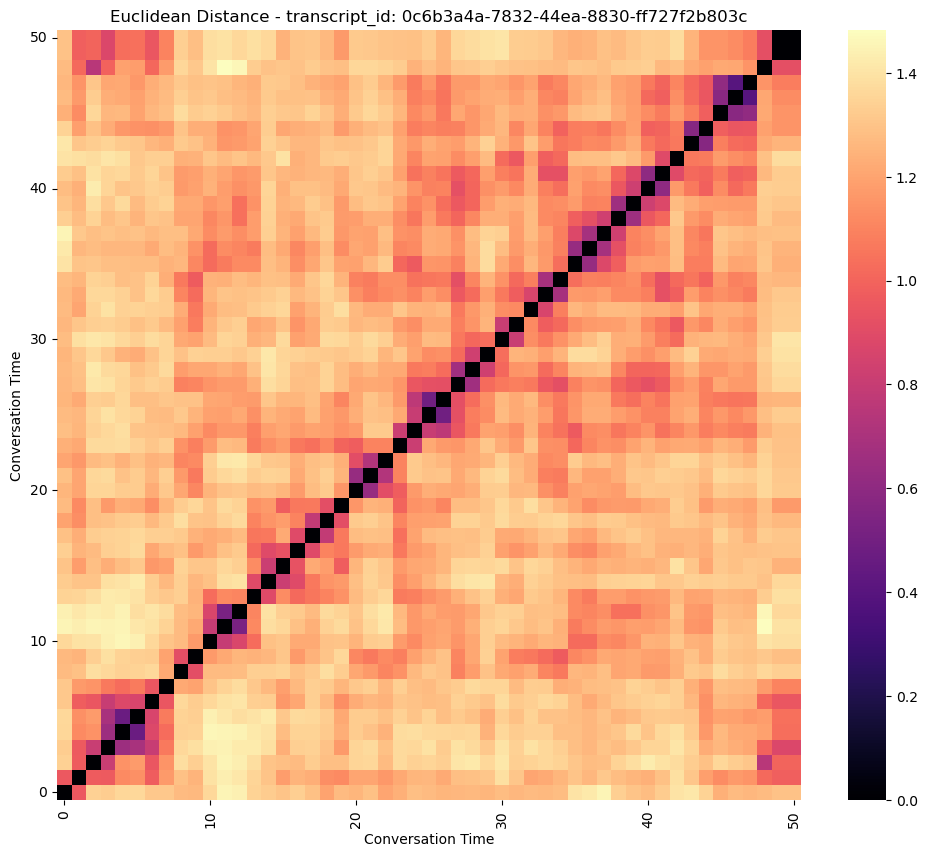

In [73]:
# example transcript
transcript_id = '0c6b3a4a-7832-44ea-8830-ff727f2b803c'
subset = tile_30_sec[tile_30_sec['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)
distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

raw_times = subset['A_start_time']

plt.figure(figsize=(12, 10))
ax = sns.heatmap(distance_matrix, annot=False, cmap='magma')

# Choose tick interval (e.g., show one every 10)
interval = 10
tick_positions = np.arange(0, len(raw_times), interval)

ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)

plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Conversation Time')
plt.ylabel('Conversation Time')
plt.show()

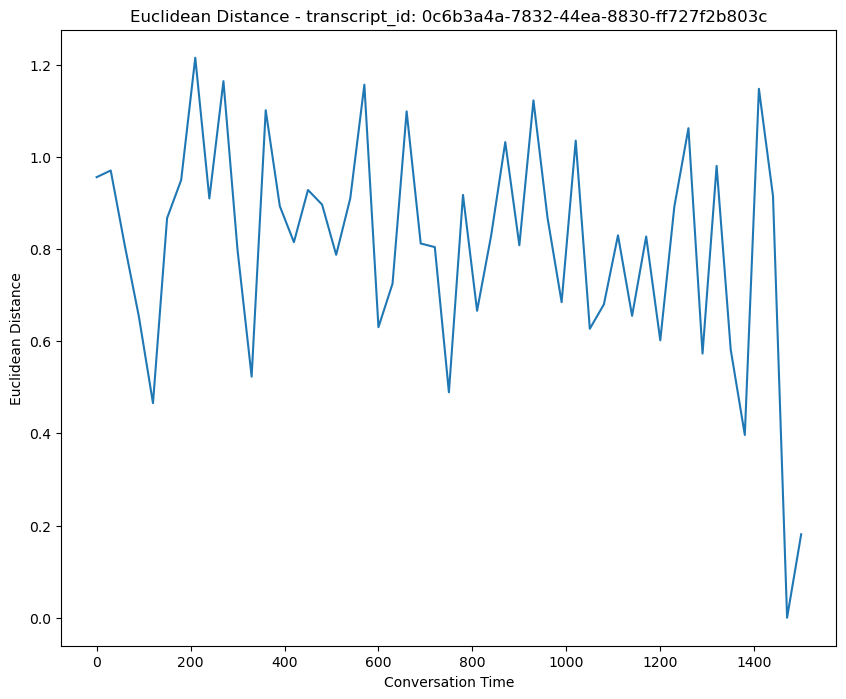

In [69]:
# plot example conversation's peaks of euclidean distances
subset = tile_30_sec[tile_30_sec['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_time', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Euclidean Distance')
plt.show()

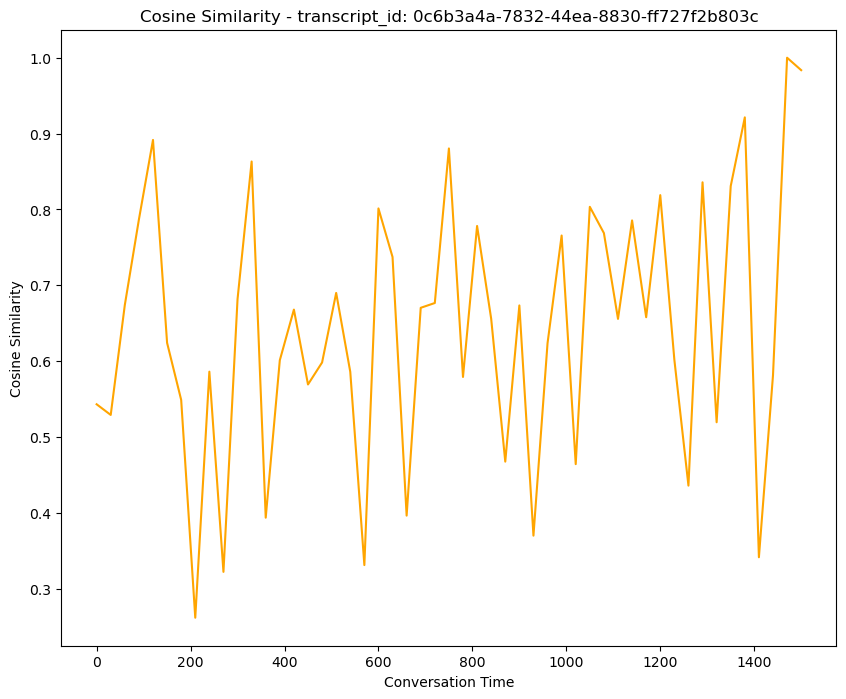

In [75]:
# plot example conversation's peaks of cosine similarities
subset = tile_30_sec[tile_30_sec['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_time', y='cosine_similarity', color = 'orange')
plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
plt.xlabel('Conversation Time')
plt.ylabel('Cosine Similarity')
plt.show()